In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-03-24 02:05:07.203623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 02:05:07.203760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 02:05:07.365966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Listing the image directories**

In [2]:
image_dir = '/kaggle/input/covid-pneumonia-normal-chest-xray-images'

classes = os.listdir(image_dir)
print(classes)

['PNEUMONIA', 'NORMAL', 'COVID']


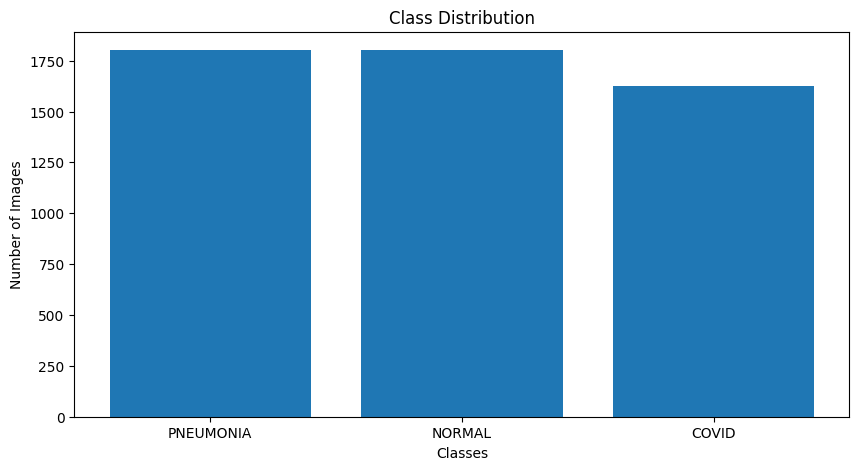

In [3]:
from collections import Counter

# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

Seems to be a balanced dataset

**Printing sample images from each classes**

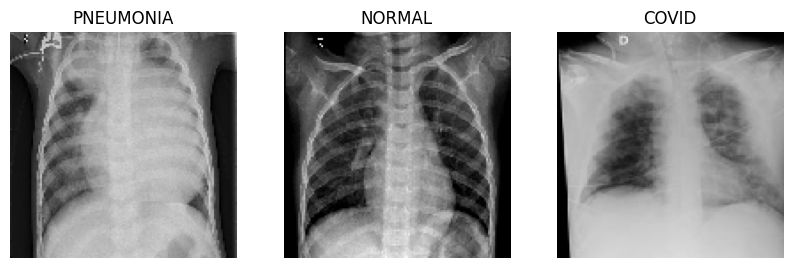

In [4]:
class_dirs = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


**Creating a Tensorflow dataset**

In [5]:
# Defining required variables
img_size = 256
batch_size = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    labels='inferred',
    label_mode='int'
)

Found 5228 files belonging to 3 classes.


**Classes**

In [6]:
class_names = dataset.class_names
print(class_names)

['COVID', 'NORMAL', 'PNEUMONIA']


In [7]:
len(dataset)

164

**Splitting above tf dataset**

In [8]:
# Let's define a function for train val test split
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True ):
    # Get dataset size
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_ds, val_ds, test_ds = split_dataset(dataset)

**Let's check the split**

In [10]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

131
16
17


Total is 164 which equals to len(dataset)

**Optimize the data pipeline for training machine learning models**

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Defining pipeline for resizing, rescaling/normalizing the data and for data augmentation**

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [13]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

**Let's define a CNN model**

In [14]:
model = Sequential()

# Apply resize_and_rescale and data augmentation
resize_and_rescale,
data_augmentation,

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,515,011 (257.55 MB)

 Trainable params: 67,514,115 (257.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20


I0000 00:00:1711245977.249687     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711245977.269494     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8293 - loss: 2.1348

W0000 00:00:1711246023.538485     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 363ms/step - accuracy: 0.8297 - loss: 2.1303 - val_accuracy: 0.7459 - val_loss: 1.5792
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9398 - loss: 0.9024 - val_accuracy: 0.9654 - val_loss: 0.7914
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9588 - loss: 0.8246 - val_accuracy: 0.9878 - val_loss: 0.6649
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9632 - loss: 0.7497 - val_accuracy: 0.9919 - val_loss: 0.6272
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9761 - loss: 0.6649 - val_accuracy: 0.9878 - val_loss: 0.6224
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.9771 - loss: 0.6222 - val_accuracy: 0.9959 - val_loss: 0.5667
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9857 - loss: 0.5925 - val_accuracy: 0.9837 - val_loss: 0.6022
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9839 - loss: 0.5532 - val

In [18]:
model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9951 - loss: 0.3216


[0.33765849471092224, 0.9942747950553894]

Pretty good accuracy

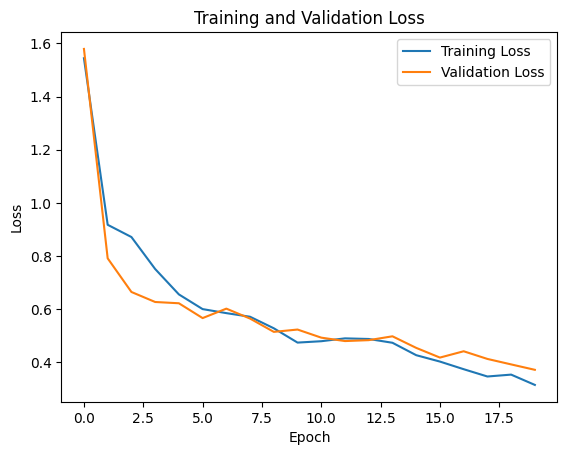

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

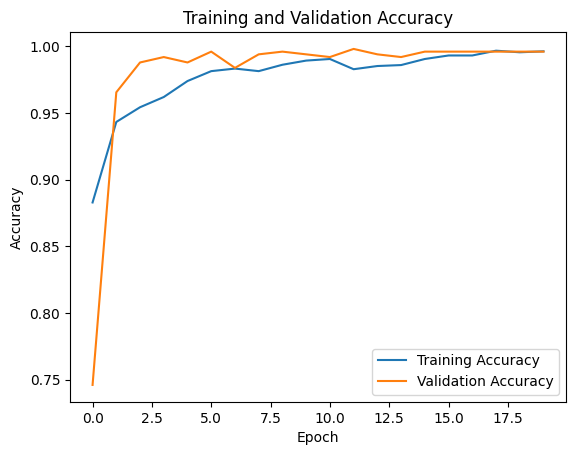

In [20]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
y_pred_probs = model.predict(test_ds)
print(y_pred_probs)

 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

W0000 00:00:1711246438.298997     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
[[1.0000000e+00 0.0000000e+00 8.7735297e-42]
 [1.0000000e+00 0.0000000e+00 2.2420775e-44]
 [1.0000000e+00 2.3298633e-12 5.2106969e-10]
 ...
 [2.2452081e-18 5.4899840e-10 1.0000000e+00]
 [2.4022030e-12 1.0000000e+00 2.3914280e-12]
 [1.4165953e-09 1.0000000e+00 2.9890359e-09]]


The predicted output is the probability of the image belonging to each separate class,this is due to softmax

In [22]:
y_pred = np.argmax(y_pred_probs, axis=1)  # This returns which column has the highest value
print(y_pred)

[0 0 0 1 2 2 2 0 2 1 2 1 1 0 2 1 2 2 1 1 1 1 0 2 2 2 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 2 0 2 1 0 1 1 0 2 2 1 1 0 2 1 2 2 0 1 1 2 0 2 2 0 1 1 2 2 2 2 1 1
 2 2 1 2 1 0 1 0 1 1 1 1 2 0 2 1 2 1 2 1 2 0 1 0 2 2 2 0 2 1 1 1 0 1 0 2 0
 0 0 0 1 0 0 2 2 2 2 1 1 1 2 1 2 2 1 2 1 2 2 2 2 0 1 0 0 0 2 2 0 0 2 2 1 1
 2 0 1 0 2 0 0 0 1 2 0 2 1 2 1 1 2 1 1 2 1 1 0 1 1 0 1 1 1 2 1 2 1 0 2 2 2
 1 0 0 1 1 2 2 1 1 2 2 1 0 0 1 0 1 1 2 0 1 0 1 2 0 1 0 2 1 2 2 0 0 0 1 2 0
 0 1 2 2 0 2 2 1 1 2 2 1 0 0 1 1 1 2 0 0 2 1 1 1 2 2 1 1 2 0 2 1 2 0 0 1 0
 2 0 1 2 1 0 2 2 1 0 1 0 2 1 2 1 0 0 0 1 1 0 2 1 0 1 0 2 2 2 1 0 0 2 1 1 2
 2 0 1 2 2 0 1 2 0 1 0 0 1 2 0 0 1 1 2 2 1 1 0 0 0 0 0 1 1 0 1 2 0 2 0 1 1
 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2 0 1 1 2 2 2 1 1 2 2 1 2 2 0 0 1 2 0 1 2 2
 1 1 0 1 0 2 2 2 1 1 0 0 2 1 2 2 1 1 1 2 2 1 0 1 0 0 2 1 0 0 1 2 0 2 0 1 1
 0 2 1 1 2 0 1 2 1 2 1 2 0 2 1 0 2 2 2 0 2 0 2 0 2 2 1 2 1 1 1 2 2 1 0 2 2
 2 0 0 1 1 1 2 2 0 2 1 0 1 1 2 1 1 0 0 1 1 0 1 1 0 0 2 1 1 2 1 0 2 0 0 1 0
 0 2 0 0 0 2 2 1 2 0 1 2 

**Let's make predictions on some sample images**

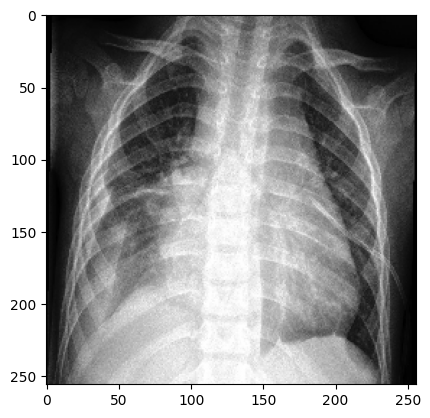

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow((images_batch[0].numpy().astype('uint8')))
# for print(images_batch[0]) , we can see this is a tensor, we convert this to numpy array before plotting image
# Instead of plt.imshow, if we print this, we will see it as a 3 dimesional array RGB

First image to predict
First images actual label:  NORMAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


W0000 00:00:1711246440.242653     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Predicted label:  NORMAL


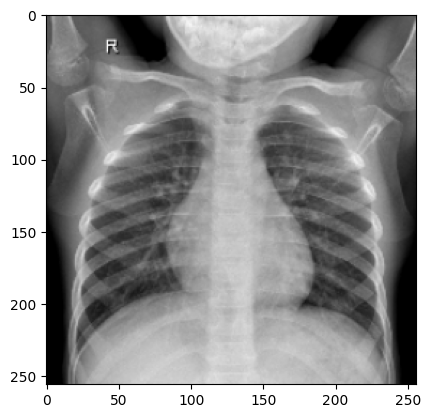

In [24]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8') 
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('First images actual label: ', class_names[first_label]) #class_names gives the names instead of 0,1 or 2
    
    batch_prediction = model.predict(images_batch)   # This is the prediction of all 32 images of the first batch
    print('Predicted label: ' , class_names[np.argmax(batch_prediction[0])])   # this is the prediction of the first image
    

Let's define a function to show the **prediction confidence** of our model.

In [25]:
def predict(model, img): # A function which takes model and image as input
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   # convert image into image array
    img_array = tf.expand_dims(img_array, 0)    # create a batch out of it

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Let's run the prediction on some samples from test dataset 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


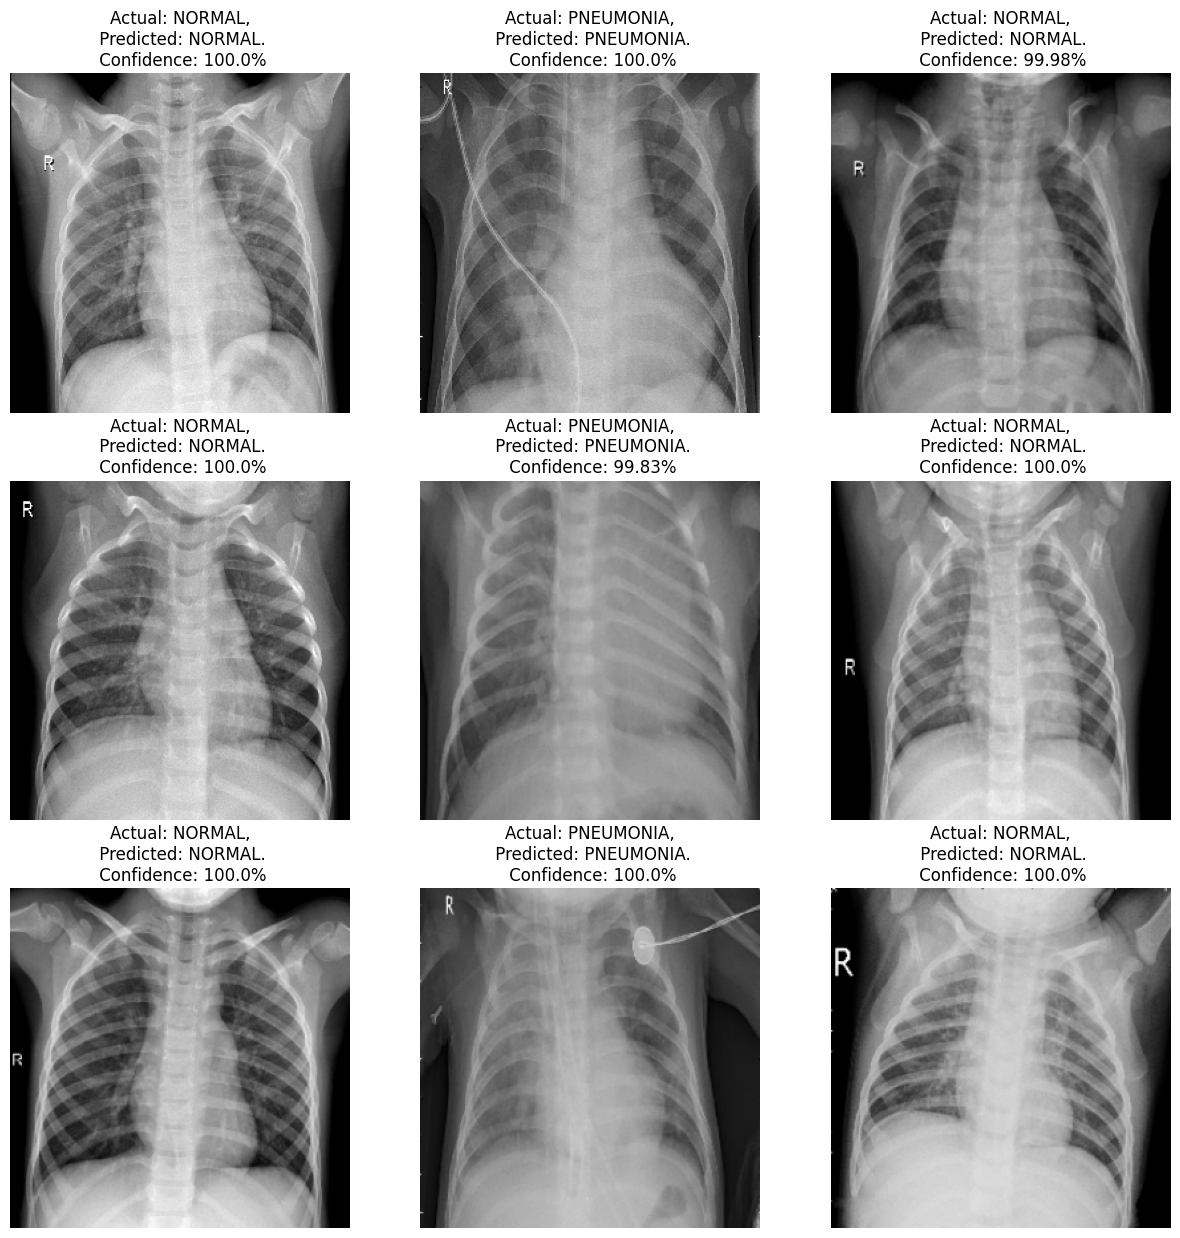

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):     # picking first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)  # subplot to show all the images
        plt.imshow(images[i].numpy().astype("uint8"))   # Show the image
        
        predicted_class, confidence = predict(model, images[i].numpy())  # Using above defined function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")  # Turn off the grid